In [3]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Fine-tune a pretrained model

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. 🤗 Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique. In this tutorial, you will fine-tune a pretrained model with a deep learning framework of your choice:

* Fine-tune a pretrained model with 🤗 Transformers [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer).
* Fine-tune a pretrained model in TensorFlow with Keras.
* Fine-tune a pretrained model in native PyTorch.

<a id='data-processing'></a>

## Prepare a dataset

Before you can fine-tune a pretrained model, download a dataset and prepare it for training. The previous tutorial showed you how to process data for training, and now you get an opportunity to put those skills to the test!

Begin by loading the [Yelp Reviews](https://huggingface.co/datasets/yelp_review_full) dataset:

In [4]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df_train_full = pd.read_csv('rusentitweet_train_v2.csv')
df_test = pd.read_csv('rusentitweet_test_v2.csv')

le = preprocessing.LabelEncoder()
le.fit(df_train_full['label'])
df_train_full['label'] = le.transform(df_train_full['label'])
df_test['label'] = le.transform(df_test['label'])

df_train, df_validation = train_test_split(df_train_full, test_size=0.15, random_state=42)

df_validation[['text', 'label']].to_csv('rusentitweet_validation_hf.csv', index=False)
df_train[['text', 'label']].to_csv('rusentitweet_train_hf.csv', index=False)
df_test[['text', 'label']].to_csv('rusentitweet_test_hf.csv', index=False)

In [5]:
le.classes_

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [6]:
le.inverse_transform([0, 1, 2, 3, 4])

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [7]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={
    'train': 'rusentitweet_train_hf.csv', 
    'test': 'rusentitweet_test_hf.csv', 
    'validation': 'rusentitweet_validation_hf.csv'
    })
dataset

Using custom data configuration default-8f44ab8ca325c113


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8f44ab8ca325c113/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9106
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2679
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1607
    })
})

As you now know, you need a tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths. To process your dataset in one step, use 🤗 Datasets [`map`](https://huggingface.co/docs/datasets/process.html#map) method to apply a preprocessing function over the entire dataset:

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### Training hyperparameters

Next, create a [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) class which contains all the hyperparameters you can tune as well as flags for activating different training options. For this tutorial you can start with the default training [hyperparameters](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments), but feel free to experiment with these to find your optimal settings.

Specify where to save the checkpoints from your training:

### Metrics

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) does not automatically evaluate model performance during training. You will need to pass [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) a function to compute and report metrics. The 🤗 Datasets library provides a simple [`accuracy`](https://huggingface.co/metrics/accuracy) function you can load with the `load_metric` (see this [tutorial](https://huggingface.co/docs/datasets/metrics.html) for more information) function:

In [9]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Trainer

Create a [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object with your model, training arguments, training and test datasets, and evaluation function:

Then fine-tune your model by calling [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report
import numpy as np

EPOCHS = 4
BATHC_SIZE = 32

model_predictions = []

for seed_number in range(3):
  model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=5)
  training_args = TrainingArguments(
      output_dir="test_trainer", 
      evaluation_strategy="epoch",
      save_strategy="epoch",
      num_train_epochs = EPOCHS,
      overwrite_output_dir = 'True',
      per_device_train_batch_size=BATHC_SIZE,
      warmup_ratio = 0.1,
      learning_rate = 2e-5,
      seed=seed_number,
      metric_for_best_model='f1',
      load_best_model_at_end=True,
    )
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics
  )
  trainer.train()
  predictions = trainer.predict(tokenized_datasets["test"])
  preds = np.argmax(predictions.predictions, axis=-1)
  model_predictions.append(preds)
  print(classification_report(tokenized_datasets["test"]['label'], preds, digits=6, target_names=le.classes_))
  trainer.save_model('trainer_rubert_rusentitweet_seed'+str(seed_number))
  model.save_pretrained('rubert_rusentitweet_seed'+str(seed_number))

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.936346,0.630367,0.619156,0.655790,0.604920
2,1.037400,0.899207,0.641568,0.630433,0.695920,0.605607
3,1.037400,0.928667,0.658992,0.652736,0.686648,0.633931
4,0.620900,0.992648,0.651525,0.646488,0.680515,0.627978


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-285
Configuration saved in test_trainer/checkpoint-285/config.json
Model weights saved in test_trainer/checkpoint-285/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-570
Configuration saved in test_trainer/checkpoint-570/config.json
Model weights saved in test_trainer/c

Saving model checkpoint to trainer_rubert_rusentitweet_seed0
Configuration saved in trainer_rubert_rusentitweet_seed0/config.json


              precision    recall  f1-score   support

    negative   0.624679  0.736364  0.675939       660
     neutral   0.711030  0.730337  0.720554      1068
    positive   0.626106  0.585921  0.605348       483
        skip   0.608527  0.425474  0.500797       369
      speech   0.755319  0.717172  0.735751        99

    accuracy                       0.663307      2679
   macro avg   0.665132  0.639054  0.647678      2679
weighted avg   0.661964  0.663307  0.659085      2679



Model weights saved in trainer_rubert_rusentitweet_seed0/pytorch_model.bin
Configuration saved in rubert_rusentitweet_seed0/config.json
Model weights saved in rubert_rusentitweet_seed0/pytorch_model.bin
loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LA

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.003259,0.606098,0.570554,0.695248,0.537825
2,1.040600,0.887618,0.660859,0.641870,0.695250,0.616397
3,1.040600,0.953375,0.654636,0.652028,0.674771,0.641919
4,0.606400,0.998327,0.659614,0.653096,0.692998,0.632240


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-285
Configuration saved in test_trainer/checkpoint-285/config.json
Model weights saved in test_trainer/checkpoint-285/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-570
Configuration saved in test_trainer/checkpoint-570/config.json
Model weights saved in test_trainer/c

Saving model checkpoint to trainer_rubert_rusentitweet_seed1
Configuration saved in trainer_rubert_rusentitweet_seed1/config.json


              precision    recall  f1-score   support

    negative   0.674041  0.692424  0.683109       660
     neutral   0.705575  0.758427  0.731047      1068
    positive   0.587452  0.639752  0.612488       483
        skip   0.658120  0.417344  0.510779       369
      speech   0.774194  0.727273  0.750000        99

    accuracy                       0.672639      2679
   macro avg   0.679876  0.647044  0.657485      2679
weighted avg   0.672509  0.672639  0.668223      2679



Model weights saved in trainer_rubert_rusentitweet_seed1/pytorch_model.bin
Configuration saved in rubert_rusentitweet_seed1/config.json
Model weights saved in rubert_rusentitweet_seed1/pytorch_model.bin
loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LA

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.957800,0.644057,0.617138,0.629913,0.613225
2,1.039200,0.876864,0.659614,0.644619,0.687888,0.620303
3,1.039200,0.920664,0.668326,0.661300,0.695066,0.640335
4,0.616700,0.984459,0.660859,0.651680,0.693438,0.630387


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-285
Configuration saved in test_trainer/checkpoint-285/config.json
Model weights saved in test_trainer/checkpoint-285/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-570
Configuration saved in test_trainer/checkpoint-570/config.json
Model weights saved in test_trainer/c

Saving model checkpoint to trainer_rubert_rusentitweet_seed2
Configuration saved in trainer_rubert_rusentitweet_seed2/config.json


              precision    recall  f1-score   support

    negative   0.681957  0.675758  0.678843       660
     neutral   0.707845  0.735019  0.721176      1068
    positive   0.596591  0.652174  0.623145       483
        skip   0.583062  0.485095  0.529586       369
      speech   0.827160  0.676768  0.744444        99

    accuracy                       0.668906      2679
   macro avg   0.679323  0.644963  0.659439      2679
weighted avg   0.668631  0.668906  0.667543      2679



Model weights saved in trainer_rubert_rusentitweet_seed2/pytorch_model.bin
Configuration saved in rubert_rusentitweet_seed2/config.json
Model weights saved in rubert_rusentitweet_seed2/pytorch_model.bin


In [13]:
from sklearn.metrics import classification_report
precisions = []
recalls = []
f1s = []
f1ws = []
for predictions in model_predictions:
  precision, recall, f1, _ = precision_recall_fscore_support(tokenized_datasets["test"]['label'], predictions, average='macro')
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)
  precision, recall, f1, _ = precision_recall_fscore_support(tokenized_datasets["test"]['label'], predictions, average='weighted')
  f1ws.append(f1)

print('Avg macro Precision', np.mean(precisions))
print('Avg macro Recall', np.mean(recalls))
print('Avg macro F1', np.mean(f1s))
print('Avg weighted F1', np.mean(f1ws))


Avg macro Precision 0.6747772329026972
Avg macro Recall 0.6436866944877477
Avg macro F1 0.654867154097531
Avg weighted F1 0.6649503767906553


In [15]:
le.classes_

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [16]:
!pip install huggingface_hub

In [14]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [17]:
from transformers import AutoModelForSequenceClassification, AutoConfig

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("/content/trainer_rubert_rusentitweet_seed2")
model.push_to_hub("sismetanin/rubert-rusentitweet")
tokenizer.push_to_hub("sismetanin/rubert-rusentitweet")

loading configuration file /content/trainer_rubert_rusentitweet_seed2/config.json
Model config BertConfig {
  "_name_or_path": "/content/trainer_rubert_rusentitweet_seed2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128

Upload file pytorch_model.bin:   0%|          | 3.34k/679M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/sismetanin/rubert-rusentitweet
   dd85507..6ba8174  main -> main

tokenizer config file saved in sismetanin/rubert-rusentitweet/tokenizer_config.json
Special tokens file saved in sismetanin/rubert-rusentitweet/special_tokens_map.json
remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/sismetanin/rubert-rusentitweet
   6ba8174..2ed6d78  main -> main



'https://huggingface.co/sismetanin/rubert-rusentitweet/commit/2ed6d78cb1941168d7eaa0446670b756f6516a34'

In [23]:
from transformers import pipeline
import numpy as np
import torch
from tqdm import tqdm

classification_results = []
classifier = pipeline("sentiment-analysis", model='sismetanin/rubert-rusentitweet', device=0)
for batch in tqdm(np.array_split(tokenized_datasets["test"]["text"], 15)):
  classification_results.extend(classifier(batch.tolist()))

loading configuration file sismetanin/rubert-rusentitweet/config.json
Model config BertConfig {
  "_name_or_path": "sismetanin/rubert-rusentitweet",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "firs

In [24]:
labels_mapper = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2,
    'LABEL_3': 3,
    'LABEL_4': 4
}
predictions = [labels_mapper[result['label']] for result in classification_results]
print(classification_report(tokenized_datasets["test"]['label'], predictions, digits=6, target_names=le.classes_))

              precision    recall  f1-score   support

    negative   0.681957  0.675758  0.678843       660
     neutral   0.707845  0.735019  0.721176      1068
    positive   0.596591  0.652174  0.623145       483
        skip   0.583062  0.485095  0.529586       369
      speech   0.827160  0.676768  0.744444        99

    accuracy                       0.668906      2679
   macro avg   0.679323  0.644963  0.659439      2679
weighted avg   0.668631  0.668906  0.667543      2679



Normalized confusion matrix


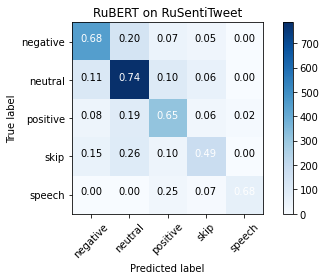

In [27]:
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim([4.5, -0.5])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.title('RuBERT on RuSentiTweet')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_rusentitweet.png', dpi=300, bbox_inches = "tight")

cnf_matrix = confusion_matrix(tokenized_datasets["test"]['label'], predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=le.classes_, normalize=True,
                    title='Normalized confusion matrix')
plt.show()

In [28]:
df_error_analysis = pd.DataFrame({
    'label': le.inverse_transform(tokenized_datasets["test"]['label']),
    'predicted_label': le.inverse_transform(predictions),
    'text':  tokenized_datasets["test"]['text']
})
df_error_analysis.head()

,label,predicted_label,text
0,skip,negative,все мы помним мой ахуй https://t.co/3Kr7yzeYLC
1,positive,positive,я считаю это мем года https://t.co/xoVKj5y8Mj
2,positive,neutral,ян русский на сотку все запятые где надо🤙🏻👍🏻👍🏻...
3,skip,skip,бэк дор соти https://t.co/bYCWz4h4Sk
4,neutral,skip,@daria_karapet * терияки бойз начинает играть*


In [29]:
from IPython.display import display

for label in df_error_analysis['label'].unique():
  print('True label:', label)
  display(df_error_analysis[(df_error_analysis['label']==label)&(df_error_analysis['predicted_label']!=label)].sample(15, random_state=1))

True label: skip


,label,predicted_label,text
395,skip,neutral,картинка смешная а ситуация страшная https://t...
886,skip,neutral,@MsBZZZZ Высокий
1560,skip,neutral,@lisoff_ Да!
1622,skip,speech,@redisOchka_aa Господу Богу
1109,skip,neutral,«Верните лекарства больным муковисцидозом» - П...
2139,skip,positive,"Отремонтировали, спасибо. Но на следующий день..."
457,skip,neutral,Открывай! https://t.co/4lzJ0uAkRP
1399,skip,neutral,@L_Traveler__ @Shisharka_ @nikoJaBitna ќорла ...
1328,skip,neutral,Ультрачилл с моей девочкой @toki_wo_tomare_ ht...
1294,skip,negative,@uyunto ты не лохушка ЛОЛ я тебе завидую.... у...


True label: positive


,label,predicted_label,text
619,positive,neutral,"хочу новую зубную щетку, такую же красную, как..."
2215,positive,neutral,@dima_leemon В фнл полно мест для российских и...
66,positive,negative,"@vladsubbotin крутая мышь, но мне не надо столько"
2398,positive,negative,@vmadi_ ОХУЕННАЯ ИДЕЧ
1966,positive,neutral,"Тот, кто придумал доставку продуктов, гениален..."
182,positive,negative,"Скучаю каждый день, что мы не видимся"
1278,positive,neutral,@oleg_zf Видимо 😁 Да и то в фикс прайсе надо п...
293,positive,skip,@tuluuna и тебе🥺💖
1381,positive,neutral,@jansoulx вышла классная и легкая дорама но та...
226,positive,negative,Я попала в пиратский би тикток\r\n👁️👄👁️


True label: neutral


,label,predicted_label,text
861,neutral,positive,@chunghamygff Я была бы не против🥺
2406,neutral,negative,@iosonodio_wry ДА НЕ ХОРНИ Я НА НЕГО
517,neutral,negative,@jopka_ogurca @vulnerablekidd @kinda_eboshiki ...
916,neutral,negative,устраиваюсь завтра работать в колледж\r\nэто ч...
2392,neutral,negative,ладно этого стоило ожидать\r\nпошел сильный ли...
2080,neutral,positive,@elieniex алтайский край😭😭😭
741,neutral,skip,Так и хочется выйти на сцену Олимпийского и пр...
1182,neutral,negative,этот твит не является призывом к действиям но ...
117,neutral,positive,@rostyarb Я могу даже особый патриотический на...
1709,neutral,skip,@69notyourfriend @jonmsokk @wttwinter пхахаха ...


True label: negative


,label,predicted_label,text
1324,negative,neutral,Каждый грех сильнее и хитрее предыдущего. Сниз...
2569,negative,skip,@AlinagonnaDie ССАНЫЕ
1317,negative,skip,"@DmAstaroth поглядите ка, еще кобенится"
1320,negative,skip,@nJXCxaqKux6PlP5 @MoskRussia @redsquare2018 На...
565,negative,positive,ОХТЫЖБЛЯТЬ https://t.co/azoH6rMiEe
305,negative,skip,@makuhaze ЧТО ЬЛЯТЬ???? МАРИОЛА????
615,negative,neutral,Su ka где мой гадс меню? https://t.co/J1hFHXcke3
1888,negative,neutral,@kQTWK2pwWHNHN2l Алёна лох
34,negative,neutral,НЕ НУ ВЫ ВИДЕЛИ ЧЕ ТВОРЯТ???\r\n\r\n#NCT127 #P...
291,negative,neutral,@Voljanin3_0 Почему ты не можешь ответить на в...


True label: speech


,label,predicted_label,text
2160,speech,skip,@paulcombrig :3 спосеба!
256,speech,positive,"@_skotina СПАСИБО, ТЕПЕРЬ Я ЗНАЮ С КЕМ ТЕБЯ ШИ..."
1600,speech,positive,"@teaempress_ Ох, спасибки❤️"
1359,speech,positive,@Toukolina приветули 😊
1706,speech,positive,@urijoo_ как дела моя хорошая?? (๑╹ω╹๑ )
1298,speech,skip,@hopemydad фух выдыхаю спасибо полина алина он...
1505,speech,positive,@Volodarskiyy Так))) Доброго)) https://t.co/h0...
2349,speech,skip,с нг
1453,speech,positive,@BTS_twt СПАСИБО ТЕБЕ Я ТЕБЯ ЛЮБЛЮ
1059,speech,positive,@johnnyjsyh не за что зай😘😘😘😘


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [30]:
def get_df_sample(label):
  return df_error_analysis[(df_error_analysis['label']==label)&(df_error_analysis['predicted_label']!=label)].sample(50, random_state=2)

get_df_sample('skip')

,label,predicted_label,text
274,skip,neutral,@yagodnoe_ochko не бойся
1294,skip,negative,@uyunto ты не лохушка ЛОЛ я тебе завидую.... у...
457,skip,neutral,Открывай! https://t.co/4lzJ0uAkRP
62,skip,positive,@kto_are_you @Noname89270295 @Eblankarakuli Он...
616,skip,neutral,Ким Сону сказал ✨✨✨✨свет
23,skip,neutral,@yoonjinmadads Дио Эксо-л🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰
1174,skip,negative,"@kizechka Несмешные шутки я не лайкаю, но у те..."
382,skip,neutral,@DexterMorgan271 @Elena46726081 @valerian_msk ...
2206,skip,positive,— ꒰‧⁺ дружеское напоминание: если бы не Алан Т...
1573,skip,neutral,@UNnaSztaszyai5 Китайцы уже медитируют на прощ...


In [31]:
get_df_sample('neutral')

,label,predicted_label,text
76,neutral,negative,@J3EhcJjfgGsGQ83 @M_Borzykin При чем тут удар ...
2112,neutral,skip,@goldenkookmad ДА!
2293,neutral,negative,@pollumy ПОДОЖДИ НУ МНЕ КАЗАЛОСЬ ДА
1925,neutral,negative,я просто устала их прятать.
2488,neutral,negative,"@TerakadoTsuuSup Да, я сейчас на дистанционке,..."
904,neutral,positive,@ShionZero я хочу увидеть тебя в юбке🥺💕
307,neutral,positive,@Marsiyanka228 ВОТ ТАК СМОТРЕЛ НА ЕГО ПОЯВЛЕНИ...
2045,neutral,positive,@MsKirona Значит ждём. Залпом кооп ждёт ))
55,neutral,negative,@douknowwhou это буквально ты мучача https://t...
1040,neutral,negative,не знаю как я к этому дошла честно


In [33]:
get_df_sample('positive')

,label,predicted_label,text
656,positive,neutral,На самом деле я ловлю уруру с этого облачка.
368,positive,neutral,У меня 1000 подписчиков на YouTube! #1kcreator...
674,positive,neutral,@An4r2 @glubinniescrepi Ты чем там? Я тоже хочу😂🤘
738,positive,skip,@KHUNAGUEROSEKSI неееет тыыы как ты можешь так...
205,positive,neutral,@MatchTV Там же Малиновский щас в порядке полн...
48,positive,neutral,@Umfcsamregion ну вот и дождались. спасибо.
90,positive,speech,@GONEFLUDD132 Скорейшего выздоровления и приве...
2416,positive,speech,Всё всем спокойной ночи 🌙 https://t.co/eowdd1HdwC
1084,positive,neutral,"@dankaloool Я в «а»,но пошла бы к тебе😎"
1060,positive,negative,философия от деда так и прет\r\nуважаю


In [32]:
get_df_sample('positive')

,label,predicted_label,text
656,positive,neutral,На самом деле я ловлю уруру с этого облачка.
368,positive,neutral,У меня 1000 подписчиков на YouTube! #1kcreator...
674,positive,neutral,@An4r2 @glubinniescrepi Ты чем там? Я тоже хочу😂🤘
738,positive,skip,@KHUNAGUEROSEKSI неееет тыыы как ты можешь так...
205,positive,neutral,@MatchTV Там же Малиновский щас в порядке полн...
48,positive,neutral,@Umfcsamregion ну вот и дождались. спасибо.
90,positive,speech,@GONEFLUDD132 Скорейшего выздоровления и приве...
2416,positive,speech,Всё всем спокойной ночи 🌙 https://t.co/eowdd1HdwC
1084,positive,neutral,"@dankaloool Я в «а»,но пошла бы к тебе😎"
1060,positive,negative,философия от деда так и прет\r\nуважаю


In [36]:
get_df_sample('negative')

,label,predicted_label,text
209,negative,neutral,"интересный факт: смысла в клипах тхт больше, ч..."
1936,negative,positive,@d5SayyUAL0rLSBL Столько людей смотрят КВН? Уд...
2584,negative,neutral,"Сейчас как обновлю ось, как начну материться в..."
128,negative,neutral,@anatoliisharii А надо было как серб перед тра...
664,negative,neutral,ПАКЕТИК ПОМОЩИ ОТ БЕСПОМОЩНОЙ ВЛАСТИ https://t...
1640,negative,neutral,За сутки более шести тысяч больных COVID-19 ht...
1738,negative,neutral,Начало конца нефтяной иглы.\r\n\r\nhttps://t.c...
2338,negative,positive,@Capt_Pereira И не боятся обосраться от развед...
1176,negative,neutral,"@adagamov ты дебил - это вишня , либо слива ..."
284,negative,skip,@yoongimysweety я не знаюююю😭😭😭😭😭


In [35]:
df_error_analysis[(df_error_analysis['label']=='speech')&(df_error_analysis['predicted_label']!='speech')]

,label,predicted_label,text
92,speech,positive,@NRetura Оба дизайна красивые *__*\r\nСпасибо ...
163,speech,positive,@ilowyl о нет :(( поправляйся скорее!! 🥺
194,speech,positive,@DooLeeHyung Если хочешь могу платить но если ...
256,speech,positive,"@_skotina СПАСИБО, ТЕПЕРЬ Я ЗНАЮ С КЕМ ТЕБЯ ШИ..."
289,speech,positive,посвящаю свое 25к твит девушкам басистам поп п...
299,speech,positive,@jkmysweetdaddy доброе утро 💗\r\nслучилось что...
671,speech,positive,@shelomov Здравствуйте! Передадим ваши пожелан...
716,speech,skip,@bastardomafiozo спасибо😭😭😭
838,speech,positive,"Масики, всех с наступающим👼🏻☃️\r\nЕсть кто-то ..."
922,speech,positive,@llen_lu С постарением💅💅
